In [1]:
import os, math, json, time, random
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator   # v1 (deprecated warning is ok here)
from qiskit_aer.primitives import Estimator as AerEstimator

SEED = 43
np.random.seed(SEED)
random.seed(SEED)

@dataclass
class Config:
    # model
    n_layers: int = 2
    feature_scale: float = np.pi

    shots_train: int | None = None
    lr: float = 0.1
    spsa_eps: float = 0.1
    iters: int = 200
    target_acc: float = 0.85
    batch_size: int = 32

    shots_plot: int | None = 64
    grid_points: int = 50
    grid_chunk: int = 256

    # data
    train_size: float = 0.7
    val_size: float = 0.15

CFG = Config()

In [ ]:
import pandas as pd, numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

CSV_PATH = None
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
UCI_COLS = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"]

K_FEATS = 8

def load_cleveland_uci(csv_path: str | None, url_fallback: str):
    df = pd.read_csv(csv_path or url_fallback, header=None, names=UCI_COLS, na_values="?")
    y = (df["num"].astype(float) > 0).astype(int).to_numpy()
    X_df = df.drop(columns=["num"]).apply(pd.to_numeric, errors="coerce")
    X_num = SimpleImputer(strategy="median").fit_transform(X_df)
    feature_cols = X_df.columns.tolist()
    return X_num.astype(np.float64), y.astype(int), feature_cols

X_all, y_all, feature_cols = load_cleveland_uci(CSV_PATH, UCI_URL)

if K_FEATS is not None:
    mi = mutual_info_classif(X_all, y_all, random_state=SEED)
    top_idx = np.argsort(-mi)[:K_FEATS]
    X_all = X_all[:, top_idx]
    feature_cols = [feature_cols[i] for i in top_idx]
    print("Top-K features:", feature_cols)

print("Raw shape:", X_all.shape, "| positive rate:", y_all.mean())

scaler = StandardScaler().fit(X_all)
Xz = scaler.transform(X_all)
Xenc = CFG.feature_scale * (Xz / (np.max(np.abs(Xz), axis=0, keepdims=True) + 1e-9))

# Splits
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    Xenc, y_all, test_size=1-CFG.train_size, random_state=SEED, stratify=y_all
)
rel_val = CFG.val_size / (1 - CFG.train_size)
X_val, X_te, y_val, y_te = train_test_split(
    X_tmp, y_tmp, test_size=1-rel_val, random_state=SEED, stratify=y_tmp
)

feat_labels = np.array(feature_cols)
X_tr.shape, X_val.shape, X_te.shape, feat_labels

Top-K features: ['thal', 'cp', 'ca', 'exang', 'oldpeak', 'chol', 'thalach', 'slope']
Raw shape: (303, 8) | positive rate: 0.45874587458745875


((212, 8),
 (45, 8),
 (46, 8),
 array(['thal', 'cp', 'ca', 'exang', 'oldpeak', 'chol', 'thalach', 'slope'],
       dtype='<U7'))

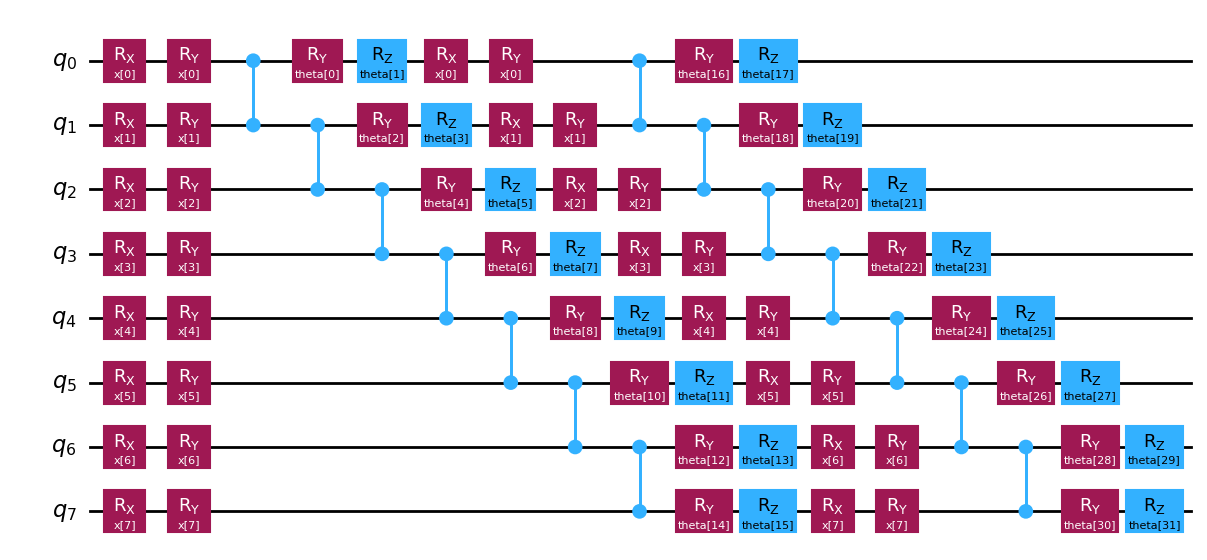

In [3]:
def build_vqc(n_features=8, n_layers=2):
    qc = QuantumCircuit(n_features, name="VQC")
    x = ParameterVector("x", n_features)
    theta = ParameterVector("theta", n_layers * n_features * 2)

    t = 0
    for _ in range(n_layers):
        # data re-upload (breaks symmetries a bit)
        for i in range(n_features):
            qc.rx(x[i], i)
            qc.ry(x[i], i)
        # CZ ladder entanglement (more stable than full ring sometimes)
        for i in range(n_features-1):
            qc.cz(i, i+1)
        # trainable block
        for i in range(n_features):
            qc.ry(theta[t], i); t += 1
            qc.rz(theta[t], i); t += 1
    return qc, x, theta

qc, x_par, th_par = build_vqc(n_features=X_tr.shape[1], n_layers=CFG.n_layers)
qc.draw('mpl')

In [4]:
PARAM_ORDER = list(x_par) + list(th_par)
print(f"[PARAM_ORDER] {len(PARAM_ORDER)} params (x:{len(x_par)} + theta:{len(th_par)})")

[PARAM_ORDER] 40 params (x:8 + theta:32)


In [ ]:
def build_theta_meta(n_features: int, n_layers: int):
    meta = []
    for L in range(n_layers):
        for q in range(n_features):
            meta.append((L, q, "rz"))
            meta.append((L, q, "ry"))
    return meta

THETA_META = build_theta_meta(n_features=X_tr.shape[1], n_layers=CFG.n_layers)
assert len(THETA_META) == len(th_par), f"Meta len {len(THETA_META)} != theta size {len(th_par)}"
print(f"[THETA_META] {len(THETA_META)} params; head:", THETA_META[:6])

[THETA_META] 32 params; head: [(0, 0, 'rz'), (0, 0, 'ry'), (0, 1, 'rz'), (0, 1, 'ry'), (0, 2, 'rz'), (0, 2, 'ry')]


In [ ]:
nq = X_tr.shape[1]
obs_label = "I"*(nq-1) + "Z"
obs = SparsePauliOp.from_list([(obs_label, 1.0)])

def build_estimator(shots):
    if shots is None:
        return Estimator()
    else:
        return AerEstimator(run_options={"shots": shots, "seed": SEED})

est_train = build_estimator(CFG.shots_train)
est_plot  = build_estimator(CFG.shots_plot)

def score_to_proba(z):  # map expectation [-1,1] -> prob[0,1]
    return (1.0 + z) * 0.5

def predict_score(theta_vals, X_batch, estimator=None):
    e = estimator or est_train
    circuits, observables = [], []
    for xb in X_batch:
        bind = {**{x_par[j]: float(xb[j]) for j in range(len(x_par))},
                **{th_par[j]: float(theta_vals[j]) for j in range(len(th_par))}}
        bound_qc = qc.assign_parameters(bind, inplace=False)
        if bound_qc.num_parameters != 0:
            raise RuntimeError(f"Circuit not fully bound: {bound_qc.num_parameters} params left")
        circuits.append(bound_qc)
        observables.append(obs)
    job = e.run(circuits, observables)
    vals = np.array(job.result().values, dtype=float).reshape(-1)
    return vals[:, None]

/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_69230/268162248.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()
/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_69230/268162248.py:14: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  est_plot  = build_estimator(CFG.shots_plot)
/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_69230/268162248.py:14: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  est_plot  = build_estimator

In [ ]:
def bce_loss(p, y):
    eps = 1e-7
    p = np.clip(p, eps, 1 - eps)
    return - (y * np.log(p) + (1 - y) * np.log(1 - p)).mean()

def batch_acc(theta, Xb, yb, estimator=None):
    z = predict_score(theta, Xb, estimator=estimator).ravel()
    p = score_to_proba(z)
    yhat = (p >= 0.5).astype(int)
    return accuracy_score(yb, yhat)

def spsa_step(theta, Xb, yb, k, a0=CFG.lr, c0=CFG.spsa_eps, estimator=None):
    d = theta.size
    delta = np.random.choice([-1.0, 1.0], size=d)
    ak = a0 / (1.0 + 0.01 * k)
    ck = c0 / (1.0 + 0.002 * k)

    thetap = theta + ck * delta
    thetam = theta - ck * delta

    z_p = predict_score(thetap, Xb, estimator=estimator).ravel()
    z_m = predict_score(thetam, Xb, estimator=estimator).ravel()
    Lp = bce_loss(score_to_proba(z_p), yb)
    Lm = bce_loss(score_to_proba(z_m), yb)
    ghat = (Lp - Lm) / (2.0 * ck) * delta
    new_theta = theta - ak * ghat
    return new_theta, Lp, Lm

def train_vqc_spsa(X_tr, y_tr, X_val, y_val, iters=CFG.iters, batch_size=CFG.batch_size):
    theta = np.random.uniform(-0.1, 0.1, size=len(th_par))
    history = {"train_loss": [], "val_acc": []}
    for k in range(1, iters+1):
        idx = np.random.choice(len(X_tr), size=min(batch_size, len(X_tr)), replace=False)
        Xb, yb = X_tr[idx], y_tr[idx]
        theta, Lp, Lm = spsa_step(theta, Xb, yb, k, estimator=est_train)

        z = predict_score(theta, Xb, estimator=est_train).ravel()
        train_loss = bce_loss(score_to_proba(z), yb)
        val_acc = batch_acc(theta, X_val, y_val, estimator=est_train)

        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)

        if k % 10 == 0:
            print(f"Iter {k:03d} | train_loss={train_loss:.4f} | val_acc={val_acc*100:.1f}%")
        if val_acc >= CFG.target_acc:
            print(f"Early stop at iter {k}: val_acc={val_acc*100:.1f}%")
            break
    return theta, history

In [8]:
def split_stats():
    for name, (X, y) in {"train": (X_tr, y_tr), "val": (X_val, y_val), "test": (X_te, y_te)}.items():
        print(f"{name}: n={len(y)}, pos_rate={np.mean(y):.3f}")
split_stats()

theta_dbg = np.zeros(len(th_par))
z = predict_score(theta_dbg, X_val, estimator=est_train).ravel()
p = score_to_proba(z)
print(f"pre-train: z[min,max]=({z.min():.3f},{z.max():.3f}), p̄={p.mean():.3f}, unique ŷ={np.unique((p>=0.5).astype(int), return_counts=True)}")

train: n=212, pos_rate=0.458
val: n=45, pos_rate=0.467
test: n=46, pos_rate=0.457
pre-train: z[min,max]=(0.280,1.000), p̄=0.902, unique ŷ=(array([1]), array([45]))


In [9]:
theta_star, hist = train_vqc_spsa(X_tr, y_tr, X_val, y_val)

Iter 010 | train_loss=0.8182 | val_acc=71.1%
Early stop at iter 16: val_acc=86.7%


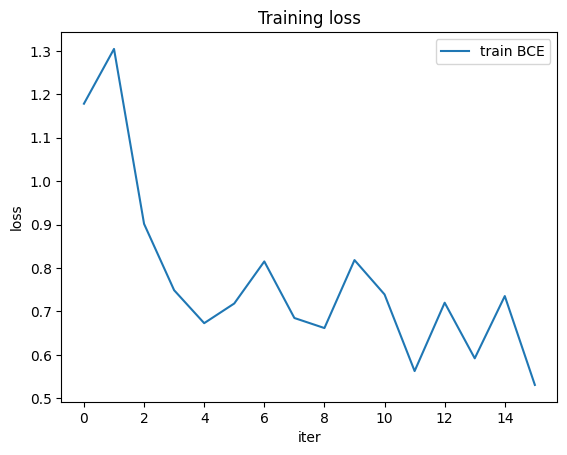

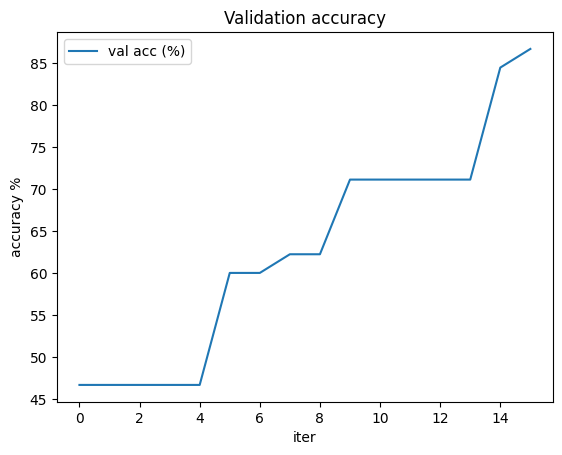

[VQC] Test accuracy: 78.26%


In [10]:
plt.figure(); plt.plot(hist["train_loss"], label="train BCE")
plt.legend(); plt.xlabel("iter"); plt.ylabel("loss"); plt.title("Training loss"); plt.show()

plt.figure(); plt.plot([a*100 for a in hist["val_acc"]], label="val acc (%)")
plt.legend(); plt.xlabel("iter"); plt.ylabel("accuracy %"); plt.title("Validation accuracy"); plt.show()

test_acc = batch_acc(theta_star, X_te, y_te, estimator=est_train)
print(f"[VQC] Test accuracy: {test_acc*100:.2f}%")

Per-feature saliency (|∂z/∂x|): [1.20348517e-02 4.61405203e-03 1.66533454e-16 1.11022302e-16
 3.33066907e-16 1.11022302e-16 1.11022302e-16 1.11022302e-16]
Global feature saliency: [2.27130955e-01 2.30719869e-02 1.16496319e-16 1.25887919e-16
 1.03206409e-16 1.23719515e-16 9.42822209e-17 1.33867647e-16]


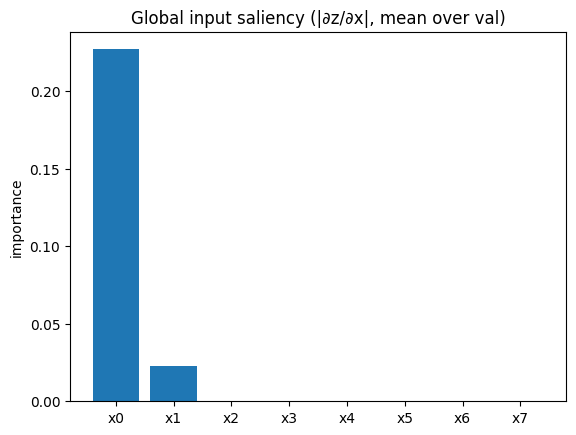

In [ ]:
PS_SHIFT = np.pi/2

def vqc_expectation(theta_vals, x_vec, estimator=None):
    return float(predict_score(theta_vals, x_vec[None, :], estimator=estimator).ravel()[0])

def grad_input_param_shift(theta_vals, x_vec, shift=PS_SHIFT, estimator=None):
    g = np.zeros_like(x_vec, dtype=float)
    for j in range(len(x_vec)):
        x_p = x_vec.copy(); x_p[j] += shift
        x_m = x_vec.copy(); x_m[j] -= shift
        z_p = vqc_expectation(theta_vals, x_p, estimator=est_train)
        z_m = vqc_expectation(theta_vals, x_m, estimator=est_train)
        g[j] = 0.5 * (z_p - z_m)
    return g  # ∂z/∂x

idx = 0
x0, y0 = X_val[idx], y_val[idx]
g_x = np.abs(grad_input_param_shift(theta_star, x0))
print("Per-feature saliency (|∂z/∂x|):", g_x)

G = np.stack([np.abs(grad_input_param_shift(theta_star, X_val[i])) for i in range(len(X_val))])
global_saliency = G.mean(axis=0)
print("Global feature saliency:", global_saliency)

plt.figure(); plt.bar(range(len(global_saliency)), global_saliency)
plt.xticks(range(X_val.shape[1]), [f"x{j}" for j in range(X_val.shape[1])])
plt.title("Global input saliency (|∂z/∂x|, mean over val)"); plt.ylabel("importance"); plt.show()

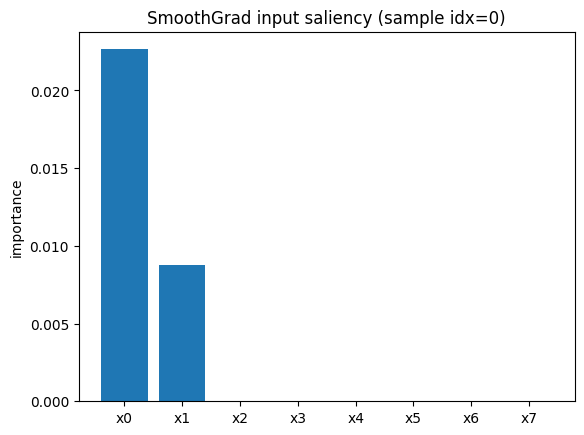

In [12]:
def smoothgrad_saliency(theta_vals, x_vec, K=30, sigma=0.1):
    grads = []
    for _ in range(K):
        x_noisy = x_vec + np.random.normal(0.0, sigma, size=x_vec.shape)
        grads.append(np.abs(grad_input_param_shift(theta_vals, x_noisy)))
    return np.mean(np.stack(grads), axis=0)

sg = smoothgrad_saliency(theta_star, x0, K=30, sigma=0.1)
plt.figure()
plt.bar(range(len(sg)), sg)
plt.xticks(range(X_val.shape[1]), [f"x{j}" for j in range(X_val.shape[1])])
plt.title("SmoothGrad input saliency (sample idx=0)"); plt.ylabel("importance")
plt.show()

Decision surface with features x0 & x1; shots_plot=64


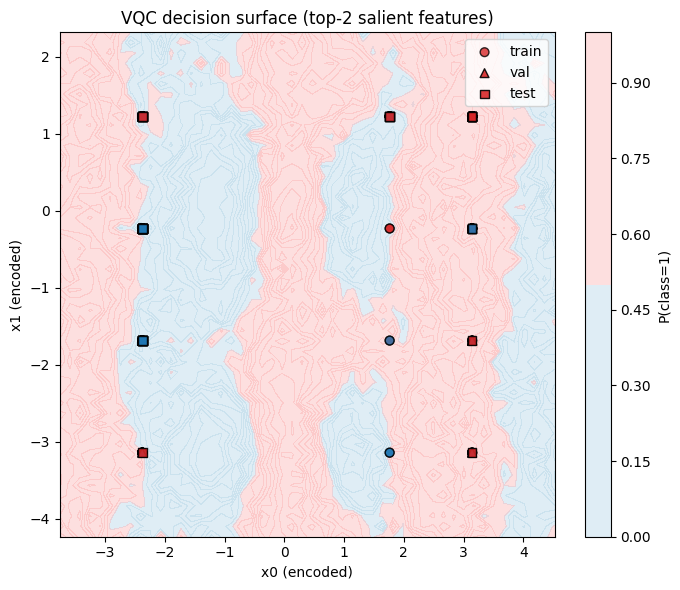

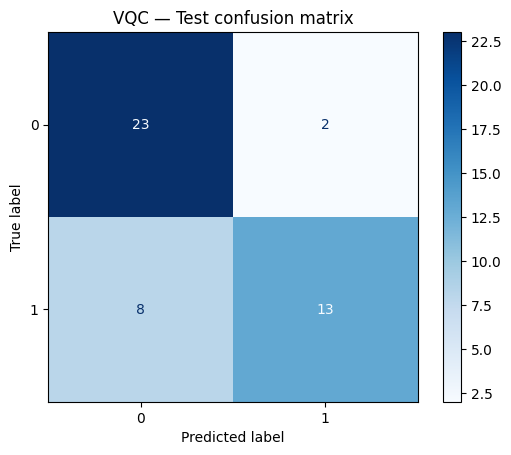

Test accuracy: 78.26%


In [ ]:
def decision_grid(theta_vals, Xref, i1, i2, n_points=None, estimator=None, margin=0.25):
    e = estimator or est_plot
    n_points = n_points or CFG.grid_points

    f1_min, f1_max = Xref[:, i1].min(), Xref[:, i1].max()
    f2_min, f2_max = Xref[:, i2].min(), Xref[:, i2].max()
    dx1, dx2 = f1_max - f1_min, f2_max - f2_min
    f1_min -= margin * dx1; f1_max += margin * dx1
    f2_min -= margin * dx2; f2_max += margin * dx2

    xx, yy = np.meshgrid(np.linspace(f1_min, f1_max, n_points),
                         np.linspace(f2_min, f2_max, n_points))

    grid_pts = np.zeros((n_points*n_points, Xref.shape[1]), dtype=float)
    grid_pts[:, i1] = xx.ravel()
    grid_pts[:, i2] = yy.ravel()

    probs = np.empty((grid_pts.shape[0],), dtype=float)
    for s in range(0, grid_pts.shape[0], CFG.grid_chunk):
        batch = grid_pts[s:s+CFG.grid_chunk]
        z = predict_score(theta_vals, batch, estimator=e).ravel()
        probs[s:s+CFG.grid_chunk] = score_to_proba(z)
    return xx, yy, probs.reshape(xx.shape)

# choose top-2 salient features by global_saliency
top2 = np.argsort(global_saliency)[-2:]
i1, i2 = sorted(top2.tolist())
print(f"Decision surface with features x{i1} & x{i2}; shots_plot={CFG.shots_plot}")

xx, yy, p = decision_grid(theta_star, Xenc, i1, i2, estimator=est_plot)

def scatter_split(ax, Xpart, ypart, label, marker, alpha=0.9):
    ax.scatter(Xpart[:, i1], Xpart[:, i2], c=ypart,
               cmap=ListedColormap(["#1f77b4","#d62728"]),
               edgecolors="k", s=40, marker=marker, label=label, alpha=alpha)

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, p, levels=np.linspace(0,1,21), alpha=0.35,
             cmap=ListedColormap(["#A6CEE3","#FCA5A5"]))
plt.colorbar(label="P(class=1)")
scatter_split(plt.gca(), X_tr, y_tr, "train", "o", 0.8)
scatter_split(plt.gca(), X_val, y_val, "val", "^", 0.9)
scatter_split(plt.gca(), X_te,  y_te,  "test", "s", 0.9)
plt.xlabel(f"x{i1} (encoded)"); plt.ylabel(f"x{i2} (encoded)")
plt.title("VQC decision surface (top-2 salient features)")
plt.legend(); plt.tight_layout(); plt.show()

z_te = predict_score(theta_star, X_te, estimator=est_train).ravel()
p_te = score_to_proba(z_te)
yhat_te = (p_te >= 0.5).astype(int)
cm = confusion_matrix(y_te, yhat_te, labels=[0,1])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot(cmap="Blues", values_format="d")
plt.title("VQC — Test confusion matrix"); plt.show()

print(f"Test accuracy: {(yhat_te==y_te).mean()*100:.2f}%")

In [ ]:
import copy
from numpy.random import RandomState

def spearman_corr(a, b):
    ra = np.argsort(np.argsort(a))
    rb = np.argsort(np.argsort(b))
    return np.corrcoef(ra, rb)[0,1]

def run_once_with_seed(seed, shots_train):
    global est_train

    est_train = build_estimator(shots_train)

    np.random.seed(seed); random.seed(seed)

    theta, hist = train_vqc_spsa(X_tr, y_tr, X_val, y_val)

    # Metrics
    acc_te = batch_acc(theta, X_te, y_te, estimator=est_train)

    # Global saliency on val
    G = np.stack([np.abs(grad_input_param_shift(theta, X_val[i])) for i in range(len(X_val))])
    glob = G.mean(axis=0)
    return acc_te, glob, theta

def stability_suite(shots_train, seeds=(1,2,3,4,5)):
    accs, globs = [], []
    for s in seeds:
        acc, glob, _ = run_once_with_seed(s, shots_train)
        accs.append(acc); globs.append(glob)
    accs = np.array(accs); globs = np.stack(globs)
    # Spearman vs first seed
    rhos = [spearman_corr(globs[0], globs[i]) for i in range(1, len(seeds))]
    return accs, globs, rhos

print("== Exact (shots=None) ==")
accs_exact, globs_exact, rhos_exact = stability_suite(shots_train=None)
print(f"Test acc mean±std: {accs_exact.mean()*100:.1f} ± {accs_exact.std()*100:.1f}%")
print(f"Saliency stability (Spearman vs seed0): {np.round(rhos_exact,3)}")

# print("\n== Shot-based (shots=10) ==")
# accs_shot, globs_shot, rhos_shot = stability_suite(shots_train=10)
# print(f"Test acc mean±std: {accs_shot.mean()*100:.1f} ± {accs_shot.std()*100:.1f}%")
# print(f"Saliency stability (Spearman vs seed0): {np.round(rhos_shot,3)}")

== Exact (shots=None) ==


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_69230/268162248.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()


Iter 010 | train_loss=0.6040 | val_acc=75.6%
Iter 020 | train_loss=0.5826 | val_acc=75.6%
Iter 030 | train_loss=0.4917 | val_acc=75.6%
Iter 040 | train_loss=0.4617 | val_acc=75.6%
Iter 050 | train_loss=0.5410 | val_acc=75.6%
Iter 060 | train_loss=0.6494 | val_acc=77.8%
Iter 070 | train_loss=0.5191 | val_acc=75.6%
Iter 080 | train_loss=0.6205 | val_acc=75.6%
Iter 090 | train_loss=0.5681 | val_acc=75.6%
Iter 100 | train_loss=0.5776 | val_acc=77.8%
Iter 110 | train_loss=0.5231 | val_acc=77.8%
Iter 120 | train_loss=0.5605 | val_acc=77.8%
Iter 130 | train_loss=0.5811 | val_acc=77.8%
Iter 140 | train_loss=0.4723 | val_acc=77.8%
Iter 150 | train_loss=0.5202 | val_acc=77.8%
Iter 160 | train_loss=0.6167 | val_acc=77.8%
Early stop at iter 167: val_acc=86.7%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_69230/268162248.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()


Iter 010 | train_loss=0.7414 | val_acc=46.7%
Iter 020 | train_loss=0.5665 | val_acc=75.6%
Iter 030 | train_loss=0.5315 | val_acc=75.6%
Iter 040 | train_loss=0.5873 | val_acc=75.6%
Iter 050 | train_loss=0.5822 | val_acc=75.6%
Iter 060 | train_loss=0.6297 | val_acc=77.8%
Iter 070 | train_loss=0.5223 | val_acc=77.8%
Iter 080 | train_loss=0.4587 | val_acc=77.8%
Iter 090 | train_loss=0.5097 | val_acc=77.8%
Iter 100 | train_loss=0.4403 | val_acc=77.8%
Iter 110 | train_loss=0.4577 | val_acc=77.8%
Iter 120 | train_loss=0.5167 | val_acc=77.8%
Iter 130 | train_loss=0.4653 | val_acc=77.8%
Iter 140 | train_loss=0.5163 | val_acc=77.8%
Iter 150 | train_loss=0.5164 | val_acc=77.8%
Iter 160 | train_loss=0.4523 | val_acc=77.8%
Iter 170 | train_loss=0.5840 | val_acc=77.8%
Iter 180 | train_loss=0.6002 | val_acc=77.8%
Iter 190 | train_loss=0.5375 | val_acc=77.8%
Iter 200 | train_loss=0.5175 | val_acc=77.8%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_69230/268162248.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()


Iter 010 | train_loss=1.0838 | val_acc=44.4%
Iter 020 | train_loss=0.5917 | val_acc=68.9%
Iter 030 | train_loss=0.5805 | val_acc=84.4%
Iter 040 | train_loss=0.6386 | val_acc=84.4%
Iter 050 | train_loss=0.5384 | val_acc=84.4%
Iter 060 | train_loss=0.5813 | val_acc=84.4%
Iter 070 | train_loss=0.5364 | val_acc=84.4%
Iter 080 | train_loss=0.5741 | val_acc=84.4%
Iter 090 | train_loss=0.5684 | val_acc=84.4%
Iter 100 | train_loss=0.6018 | val_acc=84.4%
Iter 110 | train_loss=0.5316 | val_acc=84.4%
Iter 120 | train_loss=0.4219 | val_acc=84.4%
Iter 130 | train_loss=0.5841 | val_acc=84.4%
Iter 140 | train_loss=0.5630 | val_acc=84.4%
Iter 150 | train_loss=0.4958 | val_acc=84.4%
Iter 160 | train_loss=0.5606 | val_acc=84.4%
Iter 170 | train_loss=0.6048 | val_acc=84.4%
Iter 180 | train_loss=0.5421 | val_acc=84.4%
Early stop at iter 187: val_acc=86.7%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_69230/268162248.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()


Iter 010 | train_loss=0.8696 | val_acc=46.7%
Iter 020 | train_loss=0.8929 | val_acc=46.7%
Iter 030 | train_loss=0.8177 | val_acc=46.7%
Iter 040 | train_loss=0.7271 | val_acc=57.8%
Iter 050 | train_loss=0.7265 | val_acc=51.1%
Iter 060 | train_loss=0.7157 | val_acc=51.1%
Iter 070 | train_loss=0.7240 | val_acc=62.2%
Iter 080 | train_loss=0.6595 | val_acc=77.8%
Iter 090 | train_loss=0.6490 | val_acc=80.0%
Iter 100 | train_loss=0.6366 | val_acc=75.6%
Iter 110 | train_loss=0.5506 | val_acc=75.6%
Iter 120 | train_loss=0.5488 | val_acc=75.6%
Iter 130 | train_loss=0.6105 | val_acc=75.6%
Iter 140 | train_loss=0.7083 | val_acc=75.6%
Iter 150 | train_loss=0.6843 | val_acc=75.6%
Iter 160 | train_loss=0.5343 | val_acc=75.6%
Iter 170 | train_loss=0.6799 | val_acc=73.3%
Iter 180 | train_loss=0.6579 | val_acc=73.3%
Iter 190 | train_loss=0.4427 | val_acc=73.3%
Iter 200 | train_loss=0.5398 | val_acc=73.3%


/var/folders/bb/rmrsjk6914xdvzdh57ks058r0000gn/T/ipykernel_69230/268162248.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  return Estimator()


Iter 010 | train_loss=0.5801 | val_acc=64.4%
Iter 020 | train_loss=0.5410 | val_acc=77.8%
Iter 030 | train_loss=0.4758 | val_acc=77.8%
Iter 040 | train_loss=0.5451 | val_acc=77.8%
Iter 050 | train_loss=0.5765 | val_acc=77.8%
Iter 060 | train_loss=0.5505 | val_acc=77.8%
Iter 070 | train_loss=0.4936 | val_acc=77.8%
Iter 080 | train_loss=0.4786 | val_acc=77.8%
Iter 090 | train_loss=0.5412 | val_acc=77.8%
Early stop at iter 92: val_acc=86.7%
Test acc mean±std: 74.3 ± 3.7%
Saliency stability (Spearman vs seed0): [0.524 0.524 0.381 0.595]


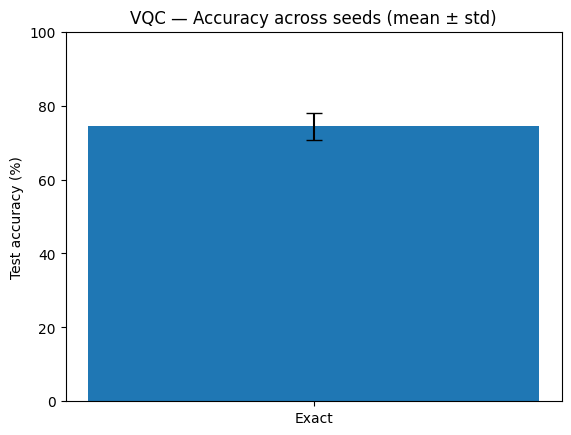

In [16]:
labels = ["Exact", "Shots=10"]
means  = [accs_exact.mean()*100] #, accs_shot.mean()*100]
stds   = [accs_exact.std()*100] #, accs_shot.std()*100]

plt.figure()
plt.bar(range(1), means, yerr=stds, capsize=6)
plt.xticks(range(1), labels[:1])
plt.ylim(0, 100)
plt.ylabel("Test accuracy (%)")
plt.title("VQC — Accuracy across seeds (mean ± std)")
plt.show()

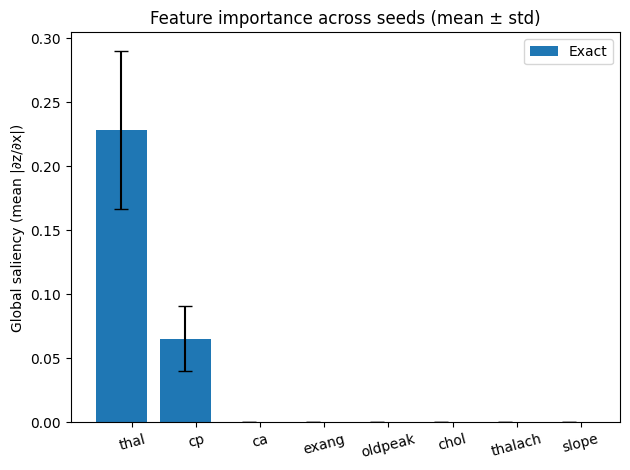

In [17]:
m_exact, s_exact = globs_exact.mean(axis=0), globs_exact.std(axis=0)
# m_shot,  s_shot  = globs_shot.mean(axis=0),  globs_shot.std(axis=0)

x = np.arange(len(feat_labels))
w = 0.35

plt.figure()
plt.bar(x - w/2, m_exact, yerr=s_exact, capsize=5, label="Exact")
# plt.bar(x + w/2, m_shot,  yerr=s_shot,  capsize=5, label="Shots=1000")
plt.xticks(x, feat_labels, rotation=15)
plt.ylabel("Global saliency (mean |∂z/∂x|)")
plt.title("Feature importance across seeds (mean ± std)")
plt.legend()
plt.tight_layout()
plt.show()

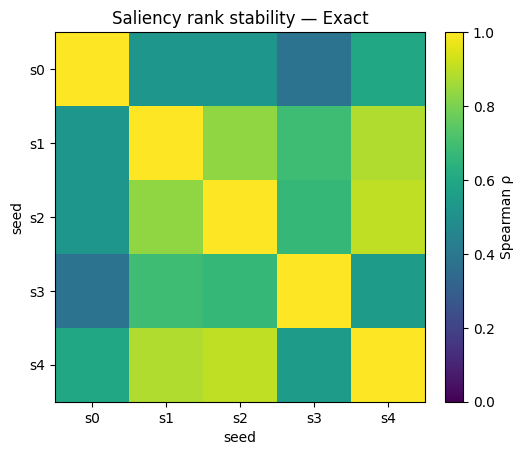

In [18]:
def pairwise_spearman(globs):
    n = globs.shape[0]
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            ra = np.argsort(np.argsort(globs[i]))
            rb = np.argsort(np.argsort(globs[j]))
            M[i,j] = np.corrcoef(ra, rb)[0,1]
    return M

M_exact = pairwise_spearman(globs_exact)
# M_shot  = pairwise_spearman(globs_shot)

def show_heatmap(M, title):
    plt.figure()
    im = plt.imshow(M, vmin=0, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04, label="Spearman ρ")
    plt.xticks(range(M.shape[0]), [f"s{i}" for i in range(M.shape[0])])
    plt.yticks(range(M.shape[0]), [f"s{i}" for i in range(M.shape[0])])
    plt.title(title)
    plt.xlabel("seed"); plt.ylabel("seed")
    plt.show()

show_heatmap(M_exact, "Saliency rank stability — Exact")
# show_heatmap(M_shot,  "Saliency rank stability — Shots=1000")

In [19]:
# Extend Config with explainability knobs
from dataclasses import replace

CFG = replace(
    CFG,
    # feature-level metrics
    )
# Constants for metrics
IG_STEPS = 25         # number of Riemann steps for Integrated Gradients
IG_BASELINE = "mean"  # 'mean' or 'zero' in encoded space
NOISE_SIGMA = 0.10    # std for noise sensitivity (in encoded units)
NOISE_K = 50          # number of MC samples for noise sensitivity

In [20]:
def feature_baseline(Xref, kind="mean"):
    """Return a baseline vector in encoded space."""
    if kind == "mean":
        return Xref.mean(axis=0)
    elif kind == "zero":
        return np.zeros(Xref.shape[1], dtype=float)
    else:
        raise ValueError("kind must be 'mean' or 'zero'")

BASELINE_VEC = feature_baseline(Xenc, kind=IG_BASELINE)

In [21]:
def grad_input_param_shift_sample(theta_vals, x_vec, shift=PS_SHIFT):
    """∂z/∂x for a single sample via parameter-shift on data-encoding RY."""
    g = np.zeros_like(x_vec, dtype=float)
    for j in range(len(x_vec)):
        x_p = x_vec.copy(); x_p[j] += shift
        x_m = x_vec.copy(); x_m[j] -= shift
        z_p = vqc_expectation(theta_vals, x_p, estimator=est_train)
        z_m = vqc_expectation(theta_vals, x_m, estimator=est_train)
        g[j] = 0.5 * (z_p - z_m)
    return g

def integrated_gradients(theta_vals, x_vec, x_base=None, m_steps=IG_STEPS):
    """
    Integrated Gradients along straight path from baseline to x:
      IG_j ≈ (x_j - x'_j) * (1/m) * Σ_k ∂z(x'_j + α_k(x_j-x'_j))/∂x_j
    """
    if x_base is None:
        x_base = BASELINE_VEC
    alphas = np.linspace(0.0, 1.0, m_steps, endpoint=True)
    grads_sum = np.zeros_like(x_vec, dtype=float)
    diff = x_vec - x_base
    for a in alphas:
        x_t = x_base + a * diff
        grads_sum += grad_input_param_shift_sample(theta_vals, x_t)
    IG = diff * (grads_sum / len(alphas))
    return IG

def gradient_times_input(theta_vals, x_vec):
    """GI = x * ∂z/∂x at the input."""
    g = grad_input_param_shift_sample(theta_vals, x_vec)
    return x_vec * g

def occlusion_importance(theta_vals, Xref, baseline_vec=None, use_loss=True):
    """
    Leave-one-out: set feature j to baseline and measure Δ (loss or prob).
    Returns vector of positive importances.
    """
    if baseline_vec is None:
        baseline_vec = BASELINE_VEC
    # base metrics
    z_base = predict_score(theta_vals, Xref, estimator=est_train).ravel()
    p_base = score_to_proba(z_base)
    if use_loss:
        base_metric = bce_loss(p_base, y_val)
    # per-feature occlusion
    importances = []
    for j in range(Xref.shape[1]):
        X_occ = Xref.copy()
        X_occ[:, j] = baseline_vec[j]
        z_occ = predict_score(theta_vals, X_occ, estimator=est_train).ravel()
        p_occ = score_to_proba(z_occ)
        if use_loss:
            metric = bce_loss(p_occ, y_val)
            imp = max(0.0, metric - base_metric)        # Δloss (positive = worse)
        else:
            imp = np.mean(np.abs(p_occ - p_base))        # Δprob
        importances.append(float(imp))
    return np.array(importances, dtype=float)

def noise_sensitivity_per_feature(theta_vals, x_vec, sigma=NOISE_SIGMA, K=NOISE_K):
    """
    Expected |Δz| when only feature j is perturbed by N(0, sigma^2).
    Returns vector of sensitivities.
    """
    base_z = vqc_expectation(theta_vals, x_vec, estimator=est_train)
    sens = np.zeros_like(x_vec, dtype=float)
    for j in range(len(x_vec)):
        diffs = []
        for _ in range(K):
            xn = x_vec.copy()
            xn[j] += np.random.normal(0.0, sigma)
            z_n = vqc_expectation(theta_vals, xn, estimator=est_train)
            diffs.append(abs(z_n - base_z))
        sens[j] = np.mean(diffs)
    return sens

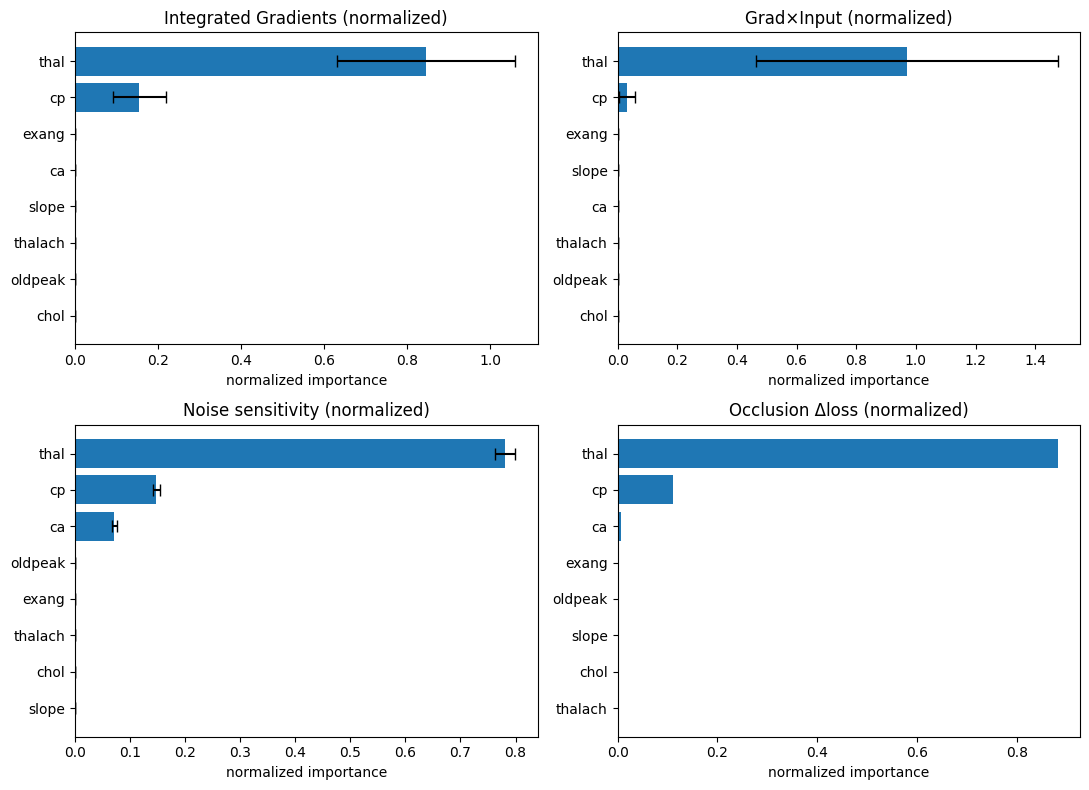

In [22]:
# -- Aggregate metrics over validation (reuse your earlier metric fns) --
idx = 0
x0, y0 = X_val[idx], y_val[idx]

def agg_metric_over_val(metric_fn):
    M = []
    for i in range(len(X_val)):
        M.append(np.abs(metric_fn(theta_star, X_val[i])))
    M = np.stack(M)
    return M.mean(axis=0), M.std(axis=0)

IG_mean, IG_std = agg_metric_over_val(lambda th, x: integrated_gradients(th, x, BASELINE_VEC, IG_STEPS))
GI_mean, GI_std = agg_metric_over_val(lambda th, x: gradient_times_input(th, x))
NS_mean, NS_std = agg_metric_over_val(lambda th, x: noise_sensitivity_per_feature(th, x, NOISE_SIGMA, NOISE_K))
OCC = occlusion_importance(theta_star, X_val, baseline_vec=BASELINE_VEC, use_loss=True)


# -- Helper to normalize within each metric so shapes are comparable --
def normalize(v, mode="sum1"):
    v = np.array(v, float)
    if mode == "sum1":
        s = v.sum()
        return v/s if s > 0 else v
    elif mode == "max1":
        m = v.max()
        return v/m if m > 0 else v
    else:
        return v

metrics = {
    "Integrated Gradients (normalized)": (normalize(IG_mean, "sum1"), IG_std),
    "Grad×Input (normalized)":           (normalize(GI_mean, "sum1"), GI_std),
    "Noise sensitivity (normalized)":    (normalize(NS_mean, "sum1"), NS_std),
    "Occlusion Δloss (normalized)":      (normalize(OCC,     "sum1"), None),
}

# -- Plotting --
import matplotlib.pyplot as plt
plt.figure(figsize=(11,8))
i = 1
for title, (mean_vec, std_vec) in metrics.items():
    order = np.argsort(-mean_vec)
    y = np.arange(len(feat_labels))
    plt.subplot(2,2,i)
    plt.barh(y, mean_vec[order], xerr=(std_vec[order] if std_vec is not None else None), capsize=4)
    plt.yticks(y, feat_labels[order])
    plt.gca().invert_yaxis()
    plt.xlabel("normalized importance")
    plt.title(title)
    i += 1
plt.tight_layout(); plt.show()

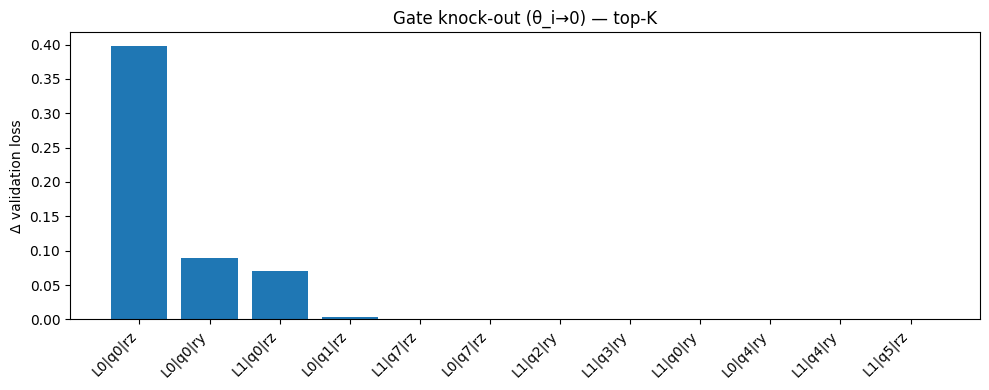

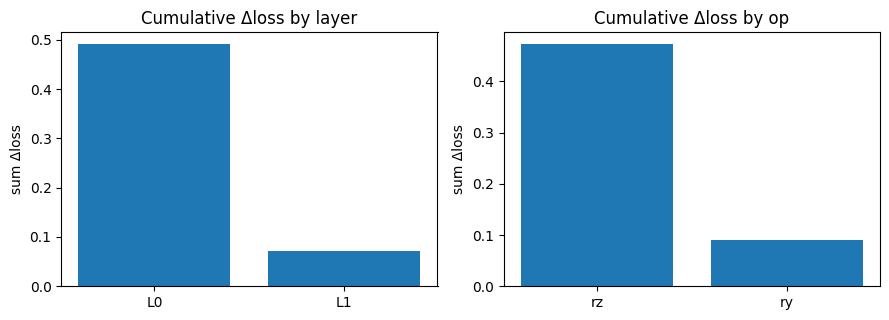

In [23]:
# Metadata for parameters: (layer, qubit, op) built earlier as THETA_META
def val_loss(theta_vals):
    z = predict_score(theta_vals, X_val, estimator=est_train).ravel()
    p = score_to_proba(z)
    return bce_loss(p, y_val)

base_L = val_loss(theta_star)
delta_losses = []
for i in range(len(theta_star)):
    th = theta_star.copy()
    th[i] = 0.0  # knock-out
    dL = val_loss(th) - base_L
    delta_losses.append(max(0.0, dL))
delta_losses = np.array(delta_losses)

# Top-K labeled bar (sorted)
K = min(12, len(delta_losses))
order = np.argsort(-delta_losses)[:K]
labels = [f"L{L}|q{q}|{op}" for (L,q,op) in np.array(THETA_META, dtype=object)[order]]

plt.figure(figsize=(10,4))
plt.bar(range(K), delta_losses[order])
plt.xticks(range(K), labels, rotation=45, ha="right")
plt.ylabel("Δ validation loss"); plt.title("Gate knock-out (θ_i→0) — top-K")
plt.tight_layout(); plt.show()

# Summaries by layer and by op type
nL = CFG.n_layers
by_layer = np.zeros(nL); by_op = {"rz":0.0, "ry":0.0}
for i, (L,q,op) in enumerate(THETA_META):
    by_layer[L] += delta_losses[i]
    by_op[op] += delta_losses[i]

plt.figure(figsize=(9,3.3))
plt.subplot(1,2,1)
plt.bar(range(nL), by_layer)
plt.xticks(range(nL), [f"L{L}" for L in range(nL)])
plt.title("Cumulative Δloss by layer"); plt.ylabel("sum Δloss")

plt.subplot(1,2,2)
plt.bar(range(len(by_op)), list(by_op.values()))
plt.xticks(range(len(by_op)), list(by_op.keys()))
plt.title("Cumulative Δloss by op"); plt.ylabel("sum Δloss")
plt.tight_layout(); plt.show()

In [24]:
import pandas as pd
def ranks_desc(v):  # 1 = most important
    return (len(v) - np.argsort(np.argsort(v)))  # 1..n ranks

df = pd.DataFrame({
    "IG_norm":  normalize(IG_mean, "sum1"),
    "GI_norm":  normalize(GI_mean, "sum1"),
    "NS_norm":  normalize(NS_mean, "sum1"),
    "OCC_norm": normalize(OCC,     "sum1"),
}, index=feat_labels)

rank_df = df.apply(ranks_desc, axis=0)
rank_df["MeanRank"] = rank_df.mean(axis=1)
display(rank_df.sort_values("MeanRank"))
print("\nNormalized scores:")
display(df.loc[rank_df.sort_values('MeanRank').index])

,IG_norm,GI_norm,NS_norm,OCC_norm,MeanRank
thal,1,1,1,1,1.00
cp,2,2,2,2,2.00
ca,4,5,3,3,3.75
exang,3,3,5,6,4.25
slope,5,4,8,4,5.25
oldpeak,7,7,4,5,5.75
thalach,6,6,6,7,6.25
chol,8,8,7,8,7.75



Normalized scores:


,IG_norm,GI_norm,NS_norm,OCC_norm
thal,8.459176e-01,9.692782e-01,7.810015e-01,8.818782e-01
cp,1.540824e-01,3.072178e-02,1.476986e-01,1.104646e-01
ca,1.228999e-16,2.150320e-16,7.129986e-02,7.657198e-03
exang,1.536779e-16,4.310064e-16,4.336135e-15,1.942452e-16
slope,9.177773e-17,3.007523e-16,4.034348e-15,1.942452e-16
oldpeak,4.664701e-17,1.112506e-16,4.518355e-15,1.942452e-16
thalach,6.178409e-17,1.456848e-16,4.239921e-15,0.000000e+00
chol,4.468437e-17,8.402043e-17,4.103585e-15,0.000000e+00


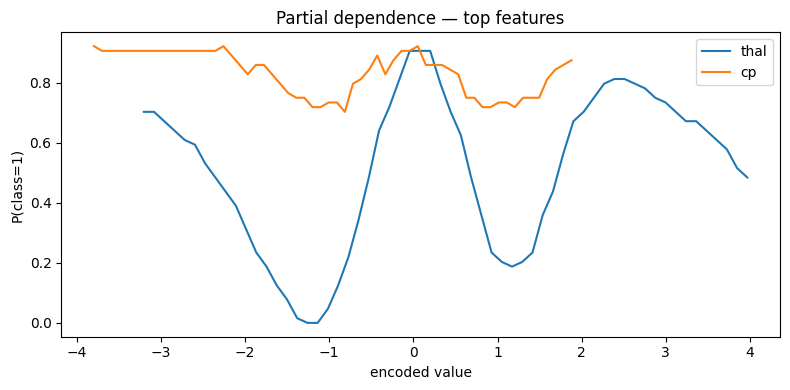

In [28]:
def partial_dependence(theta_vals, Xref, j, points=60, margin=0.15, estimator=None):
    e = estimator or est_plot
    fmin, fmax = Xref[:, j].min(), Xref[:, j].max()
    span = fmax - fmin
    xs = np.linspace(fmin - margin*span, fmax + margin*span, points)
    probs = []
    template = Xref.mean(axis=0)  # other features fixed to mean encoded value
    for xj in xs:
        x = template.copy()
        x[j] = xj
        z = vqc_expectation(theta_vals, x, estimator=e)
        probs.append(score_to_proba(z))
    return xs, np.array(probs)

# Plot for the top-2 features by IG
order = np.argsort(-IG_mean)
top2 = order[:2]
plt.figure(figsize=(8,4))
for j in top2:
    xs, ps = partial_dependence(theta_star, Xenc, j, estimator=est_plot)
    plt.plot(xs, ps, label=feat_labels[j])
plt.xlabel("encoded value"); plt.ylabel("P(class=1)")
plt.title("Partial dependence — top features")
plt.legend(); plt.tight_layout(); plt.show()